<a href="https://colab.research.google.com/github/feltri08/Music-classification/blob/main/Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/course-IA2/')
Root = "/content/drive/MyDrive/course-IA2"
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/course-IA2


In [ ]:
import os
import sys
import time

import librosa
import librosa.display

import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten

from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import clear_output

%matplotlib inline

In [ ]:
path = '/content/drive/MyDrive/course-IA2/Proyecto/models'
audio_dataset_path='/content/drive/MyDrive/course-IA2/Proyecto/Data/genres_original'
metadata=pd.read_csv('/content/drive/MyDrive/course-IA2/Proyecto/Data/features_30_sec.csv')
metadata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
#Dividimos en caudrado trozos de longitud 40 ms y separamos frecuencias
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [ ]:
extracted_features=[]
music_names = []
for index_num,row in tqdm(metadata.iterrows()):
    try:
        final_class_labels=row["label"]

        file_name = os.path.join(os.path.abspath(audio_dataset_path), final_class_labels+'/',str(row["filename"]))  
        music_names.append(file_name)

        data=features_extractor(file_name)
        extracted_features.append([data,final_class_labels])
    except Exception as e:
        clear_output(wait=True)
        print("Error, algo ha salido mal con el archivo, hagamos como que nada pasó")
        continue

974it [01:31,  9.88it/s]

Error, algo ha salido mal con el archivo, hagamos como que nada pasó


1000it [01:33, 10.68it/s]


In [ ]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-113.57065, 121.57179, -19.168142, 42.36642, ...",blues
1,"[-207.5017, 123.991264, 8.955127, 35.87765, 2....",blues
2,"[-90.722595, 140.4463, -29.09389, 31.684334, -...",blues
3,"[-199.5442, 150.09091, 5.6626782, 26.85908, 1....",blues
4,"[-160.3377, 126.219635, -35.58781, 22.148071, ...",blues


In [ ]:
extracted_features_df['class'].value_counts()

metal        100
pop          100
reggae       100
classical    100
blues        100
hiphop       100
disco        100
country      100
jazz          99
rock          99
Name: class, dtype: int64

**Split the dataset into independent and dependent dataset**

In [ ]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [ ]:
X.shape

(998, 40)

In [ ]:
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [ ]:
y.shape

(998, 10)

**Train Test Split**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
X_train

array([[-1.04974236e+02,  8.07178955e+01, -2.85339451e+01, ...,
        -1.63951254e+00,  2.63093591e-01,  2.21448675e-01],
       [-2.59876740e+02,  1.23187164e+02, -6.39084244e+00, ...,
        -6.73822832e+00, -3.91004443e+00,  3.17720938e+00],
       [-1.15707176e+02,  6.70756454e+01,  1.87352538e+00, ...,
        -3.44522524e+00, -1.73945498e+00, -4.34088111e-02],
       ...,
       [-7.74571762e+01,  1.30936478e+02, -2.33290615e+01, ...,
        -4.20865250e+00, -3.52202845e+00,  2.60719037e+00],
       [-1.90423065e+02,  1.29542053e+02, -7.84552956e+00, ...,
        -2.24016356e+00, -3.98439646e+00, -1.98053861e+00],
       [-4.65721245e+01,  8.68102798e+01, -3.47887421e+01, ...,
         1.48847297e-01,  9.24574316e-01, -8.69751930e-01]], dtype=float32)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(798, 40)
(200, 40)
(798, 10)
(200, 10)


In [ ]:
num_labels=y.shape[1]

In [ ]:
y.shape[1]

10

In [ ]:
model=Sequential()
model.add(Dense(1024,input_shape=(40,), activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(num_labels, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 1024)              41984     
_________________________________________________________________
dropout_99 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_128 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_100 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_129 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_101 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_130 (Dense)            (None, 128)             

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)

In [ ]:
checkpointer = ModelCheckpoint(filepath=f'Proyecto/models/audio_classification_{current_time}.hdf5', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=32, epochs=150, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)

Epoch 1/150
25/25 [==============================] - 2s 17ms/step - loss: 2.4974 - accuracy: 0.1429 - val_loss: 2.5030 - val_accuracy: 0.0950

Epoch 00001: val_loss did not improve from 1.21276
Epoch 2/150
25/25 [==============================] - 0s 8ms/step - loss: 2.2589 - accuracy: 0.1842 - val_loss: 2.1502 - val_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 1.21276
Epoch 3/150
25/25 [==============================] - 0s 9ms/step - loss: 2.1631 - accuracy: 0.2168 - val_loss: 2.0975 - val_accuracy: 0.2850

Epoch 00003: val_loss did not improve from 1.21276
Epoch 4/150
25/25 [==============================] - 0s 7ms/step - loss: 2.0584 - accuracy: 0.2694 - val_loss: 1.9044 - val_accuracy: 0.3350

Epoch 00004: val_loss did not improve from 1.21276
Epoch 5/150
25/25 [==============================] - 0s 7ms/step - loss: 1.9842 - accuracy: 0.2732 - val_loss: 1.8705 - val_accuracy: 0.3350

Epoch 00005: val_loss did not improve from 1.21276
Epoch 6/150
25/25 [===============

In [ ]:
model.evaluate(X_test,y_test,verbose=0)

[1.8724745512008667, 0.6449999809265137]

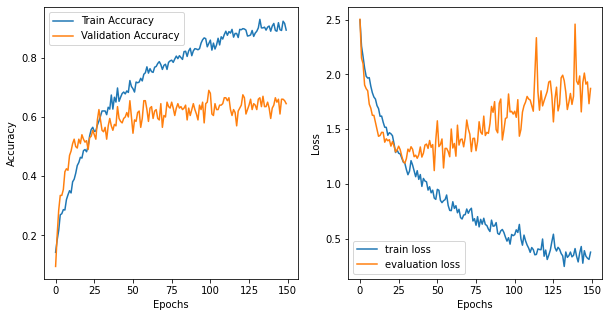

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

In [ ]:
model.predict(X_test)

array([[4.0346405e-01, 5.2435771e-05, 1.9096307e-01, ..., 2.0853762e-04,
        2.8255526e-03, 3.6305922e-01],
       [4.4261811e-38, 1.9034754e-36, 0.0000000e+00, ..., 1.0000000e+00,
        3.0589718e-25, 9.3212096e-37],
       [1.0000000e+00, 0.0000000e+00, 1.2708772e-16, ..., 0.0000000e+00,
        9.2506774e-38, 1.6910974e-18],
       ...,
       [7.5396061e-02, 6.7117676e-04, 7.8279006e-01, ..., 3.3830979e-03,
        1.3517062e-02, 9.3122952e-02],
       [1.8894210e-02, 2.2309139e-06, 9.7018808e-01, ..., 8.1403914e-06,
        1.3484673e-04, 1.0556142e-02],
       [1.2456554e-15, 9.4175971e-01, 4.4573762e-15, ..., 8.7715668e-17,
        1.1220062e-11, 2.3201832e-19]], dtype=float32)

In [ ]:
prueba = 250 #@param {type:"slider", min:0, max:997, step:1}
music_names[prueba]
audio, sample_rate = librosa.load(music_names[prueba], res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict(mfccs_scaled_features)
predicted_label = np.argmax(predicted_label, axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
print(prediction_class)
print(music_names[prueba])

[-1.4302405e+02  1.2187051e+02 -1.3352005e+01  4.7760128e+01
 -1.2661846e+01  2.3361862e+01 -1.1003620e+01  1.8853807e+01
 -1.3706390e+01  1.5944213e+01 -1.1353545e+01  1.0289694e+01
 -6.0037026e+00  2.7283385e+00 -9.2896528e+00  4.5030689e+00
 -8.3194761e+00  4.5256352e+00 -6.0261183e+00 -2.3461111e+00
 -6.2238398e+00 -1.1314468e+00 -1.1521124e+00  1.0930629e+00
  2.6120732e+00  2.6298553e-01  6.0050163e+00  4.8493996e+00
  3.9359665e-01 -1.3585094e+00 -1.9417390e+00 -3.1827968e-01
  2.5147741e+00 -1.6285464e+00 -8.0163652e-01 -3.3798323e+00
 -3.0554023e+00 -3.2734406e+00 -1.1408382e-01  3.5710523e-03]
[[-1.4302405e+02  1.2187051e+02 -1.3352005e+01  4.7760128e+01
  -1.2661846e+01  2.3361862e+01 -1.1003620e+01  1.8853807e+01
  -1.3706390e+01  1.5944213e+01 -1.1353545e+01  1.0289694e+01
  -6.0037026e+00  2.7283385e+00 -9.2896528e+00  4.5030689e+00
  -8.3194761e+00  4.5256352e+00 -6.0261183e+00 -2.3461111e+00
  -6.2238398e+00 -1.1314468e+00 -1.1521124e+00  1.0930629e+00
   2.6120732e+00 